In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs mmio_stale_data retbleed
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtua

In [ ]:
!df

Filesystem     1K-blocks     Used Available Use% Mounted on
overlay         81987992 24390768  57580840  30% /
tmpfs              65536        0     65536   0% /dev
shm              5958656        0   5958656   0% /dev/shm
/dev/root        2003760  1142612    861148  58% /usr/sbin/docker-init
/dev/sda1       80257428 45467404  34773640  57% /opt/bin/.nvidia
tmpfs            6648600     2408   6646192   1% /var/colab
tmpfs            6648600        0   6648600   0% /proc/acpi
tmpfs            6648600        0   6648600   0% /proc/scsi
tmpfs            6648600        0   6648600   0% /sys/firmware
drive           15728640        0  15728640   0% /content/drive


## Download Dataset


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown --id 1tPhPdJ6lHxvACgz2y-GWVRBhr9sBU4dd

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tPhPdJ6lHxvACgz2y-GWVRBhr9sBU4dd
To: /content/statues128.zip
100% 12.1M/12.1M [00:00<00:00, 41.2MB/s]


In [ ]:
!unzip /content/statues128.zip

Archive:  /content/statues128.zip
   creating: statues128/
   creating: statues128/valid/
  inflating: statues128/.DS_Store    
  inflating: __MACOSX/statues128/._.DS_Store  
   creating: statues128/test/
   creating: statues128/train/
  inflating: statues128/valid/statues128landmarks.json  
   creating: statues128/valid/statue/
  inflating: statues128/test/.DS_Store  
  inflating: __MACOSX/statues128/test/._.DS_Store  
  inflating: statues128/test/statues128landmarks.json  
   creating: statues128/test/statue/
  inflating: statues128/train/statues128landmarks.json  
   creating: statues128/train/statue/
  inflating: statues128/valid/statue/flickr_0211_cropped.jpg  
  inflating: statues128/valid/statue/flickr_0585_cropped.jpg  
  inflating: statues128/valid/statue/istock_0094_cropped.jpg  
  inflating: statues128/valid/statue/istock_0494_cropped.jpg  
  inflating: statues128/valid/statue/istock_1088_cropped.jpg  
  inflating: statues128/valid/statue/istock_0112_cropped.jpg  
  inflatin

In [ ]:
import os
import datetime
import imageio
import random
import numpy as np

from PIL import Image
import cv2
from skimage import io
from tqdm.auto import tqdm
from xml.etree import ElementTree
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models, datasets
from torchsummary import summary
import json
import time

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

class LandmarksDataset(Dataset):
    def __init__(self, train, mode, root_path='/content/statues128', masks_number=4, verbose=False):
        self.root_dir = f'{root_path}/{mode}/statue/'
        self.root_landmarks = f'{root_path}/{mode}/statues128landmarks.json'
        with open(self.root_landmarks) as fp:
            self.landmark_points = json.load(fp)
        self.image_paths = []
        self.landmarks = []
        self.train = train
        self.mode = mode
        self.masks_number=masks_number
        self.verbose = verbose
        self.last_object = None

        filenames = self.landmark_points.keys()
        filenames = [filename for filename in filenames if filename.split('.')[1] in ('jpg', 'jpeg', 'png')]
        filenames = sorted(filenames, key=lambda fn: (fn.split('.')[0]))

        for filename in filenames:
            path_to_img = os.path.join(self.root_dir, filename)
            self.image_paths.append(path_to_img)
            landmark = self.get_image_landmark(filename)
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')
        assert len(self.image_paths) == len(self.landmarks)

    def __len__(self):
        return len(self.image_paths)

    def set_masks_number(self, masks_number):
        self.masks_number=masks_number

    def set_verbose(self, verbose):
        self.verbose = verbose

    def get_image_landmark(self, filename):
        landmark = []
        for num in range(68):
            x_coordinate = int(self.landmark_points[filename][f'{num:02d}']['x'])
            y_coordinate = int(self.landmark_points[filename][f'{num:02d}']['y'])
            landmark.append([x_coordinate, y_coordinate])
        return landmark

    def mask_image(self, image, inplace=False, random_masks=False):

        masks_number = 2*random.randint(1, 7) if random_masks else self.masks_number
        min_mask_w, max_mask_w = 10, 30
        min_mask_h, max_mask_h = 10, 30
        if inplace:
          for i in range(masks_number):
            mask_x = random.randint(0, 128 - max_mask_w)
            mask_width = random.randint(min_mask_w, max_mask_w)
            mask_y = random.randint(0, 128 - max_mask_h)
            mask_height = random.randint(min_mask_h, max_mask_h)
            image[mask_x: mask_x + mask_width, mask_y: mask_y + mask_height] = 0
        else:
          new_image = np.copy(image)
          for i in range(masks_number):
            mask_x = random.randint(0, 128 - max_mask_w)
            mask_width = random.randint(min_mask_w, max_mask_w)
            mask_y = random.randint(0, 128 - max_mask_h)
            mask_height = random.randint(min_mask_h, max_mask_h)
            new_image[mask_x: mask_x + mask_width, mask_y: mask_y + mask_height] = 0
          return new_image


    def __getitem__(self, index):
        #image = io.imread(self.image_paths[index], as_gray=True)
        if self.verbose:
          print('filename: ', self.image_paths[index])
        self.last_object = self.image_paths[index]
        image = cv2.imread(self.image_paths[index], cv2.IMREAD_GRAYSCALE)
        self.mask_image(image, inplace=True, random_masks=True)
        img_tensor = transform(image)
        landmarks = self.landmarks[index]
        landmarks = landmarks - 0.5
        landmarks_tensor = torch.from_numpy(landmarks)
        return img_tensor.to(device), landmarks_tensor.to(device)

In [ ]:
def visualize_image(image, landmarks):
    plt.figure(figsize = (3, 3))
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s = 3, c = 'black')
    #plt.axis('off')
    plt.show()

def visualize_batch(images_list, landmarks_list, size = 14, shape = (6, 6), title = None, save = None):
    fig = plt.figure(figsize = (size, size))
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.08)
    for ax, image, landmarks in zip(grid, images_list, landmarks_list):
        landmarks = landmarks.view(-1, 2)
        ax.axis('off')

    if title:
        print(title)
    if save:
        plt.savefig(save)
    plt.show()

In [ ]:
train_dataset = LandmarksDataset(train = True, mode='train')
test_dataset = LandmarksDataset(train = False, mode='test')
valid_dataset = LandmarksDataset(train = False, mode='valid')

In [ ]:
print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))

1092
116
27


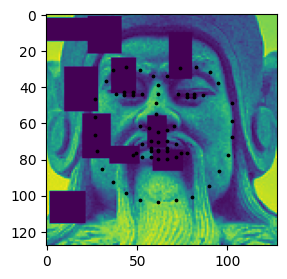

torch.Size([1, 128, 128])


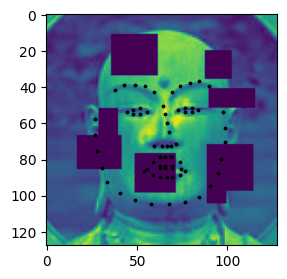

torch.Size([1, 128, 128])


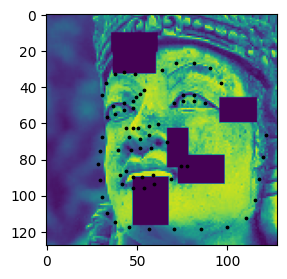

torch.Size([1, 128, 128])


In [ ]:
train_dataset.set_masks_number(2)
for i in range(3):
    image1, landmarks1 = train_dataset[i+200]
    visualize_image(image1[0].cpu(), landmarks1.cpu())
    print(image1.shape)

In [ ]:
len_train_set = len(train_dataset)
len_test_set = len(test_dataset)
len_valid_set = len(valid_dataset)

print("The length of Train set is {}".format(len_train_set))
print("The length of Test set is {}".format(len_test_set))
print("The length of Valid set is {}".format(len_valid_set))

#train_dataset , valid_dataset,  = torch.utils.data.random_split(train_dataset , [len_train_set, len_valid_set])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=True)

The length of Train set is 1092
The length of Test set is 116
The length of Valid set is 27


In [ ]:
train_loader.dataset.masks_number

2

In [ ]:
images, landmarks = next(iter(train_loader))

In [ ]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet50'
        self.model=models.resnet50()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x=self.model(x)
        return x

In [ ]:
images.shape

torch.Size([16, 1, 128, 128])

In [ ]:
Network().cuda()(images)

tensor([[ 0.9762, -0.5726,  0.0200,  ...,  0.4519,  0.2402,  0.3863],
        [ 1.0699, -0.5200, -0.0100,  ...,  0.3016,  0.1488,  0.3179],
        [ 1.3402, -0.5828,  0.9248,  ...,  0.4730,  0.4762,  0.5262],
        ...,
        [ 1.0278, -0.6884,  0.2189,  ...,  0.5267,  0.3023,  0.6465],
        [ 0.9816, -0.5414,  0.0121,  ...,  0.2180,  0.1441,  0.4732],
        [ 1.4968, -0.8206,  0.5742,  ...,  0.3563,  0.1190,  0.4417]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
os.path.exists('/content/drive/MyDrive/Postgrado/Generated/resnet18_landmarkdetector/resnet18_landmarkdetector_2023-05-02_12:16:52.log')

False

In [ ]:
import sys



def log_step(step, total_step, loss, operation, logfile_path):
    writemode = 'a' if os.path.exists(logfile_path) else 'w'
    with open(logfile_path, writemode) as logfile:
        if operation == 'train':
            print("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        else:
            print("Valid Steps: %d/%d  Loss: %.4f \n" % (step, total_step, loss))

def log_info(logfile_path, msg):
    writemode = 'a' if os.path.exists(logfile_path) else 'w'
    with open(logfile_path, writemode) as logfile:
        print(msg, sep='', end='')
        logfile.write(msg)

## Model Summary

In [ ]:
!pip install torchinfo

In [ ]:
import torchinfo
torchinfo.summary(Network())

Layer (type:depth-idx)                        Param #
Network                                       --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─Bottleneck: 3-1                   75,008
│    │    └─Bottleneck: 3-2                   70,400
│    │    └─Bottleneck: 3-3                   70,400
│    └─Sequential: 2-6                        --
│    │    └─Bottleneck: 3-4                   379,392
│    │    └─Bottleneck: 3-5                   280,064
│    │    └─Bottleneck: 3-6                   280,064
│    │    └─Bottleneck: 3-7                   280,064
│    └─Sequential: 2-7                        --
│    │    └─Bottleneck: 3-8                   1,512,448
│    │    └─Bottleneck: 3-9                   1,117,184
│    │    └─Bo

## Load a pretrained model

In [ ]:
network = Network()
network.to(device)
network.load_state_dict(torch.load('/content/drive/MyDrive/Postgrado/Generated/resnet_landmarkdetector/resnet50_landmarkdetector_2023-01-29_15:59:53.pth'))

RuntimeError: ignored

## Train model from scratch

In [ ]:
network = Network()
network.to(device)
train_masks_number = 2
torch.autograd.set_detect_anomaly(True)
train_id = datetime.datetime.now().strftime('resnet50_landmarkdetector_%Y-%m-%d_%H:%M:%S')
criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

epoch_array      = []
train_loss_array = []
valid_loss_array = []

loss_min = np.inf
epoch = 0

start_time = time.time()
logfile_path = f'/content/drive/MyDrive/Postgrado/Generated/resnet50_landmarkdetector/{train_id}.log'

In [ ]:
def test_landmarks_predictor(train, mode, dataloader, save=False):

    #dataset = LandmarksDataset(train = train, mode=mode, masks_number=5, verbose=False)
    #dataloader = torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=False)
    iterloader = iter(dataloader)
    fig = plt.figure(figsize=(9, 5))
    for i in range(3):

        images, real_landmarks = next(iterloader)

        # init figure

        #fig.suptitle(t=f'Figure: {dataloader.dataset.last_object.split("/")[-1]}')

        # show source image
        #ax0 = fig.add_subplot(1, 3, 1)
        #plt.imshow(cv2.imread(dataloader.dataset.last_object))

        # show ground truth landmarks
        ax1 = fig.add_subplot(1, 2, 1)
        plt.imshow(images[0][0].cpu())
        plt.scatter(real_landmarks[0].cpu()[:, 0], real_landmarks[0].cpu()[:, 1], s = 3, c = 'red', label='ground truth')
        plt.axis('off')
        plt.legend()


        # show predicted landmarks
        ax2 = fig.add_subplot(1, 2, 2)
        predicted_landmarks = network(images)
        predicted_landmarks = predicted_landmarks.detach()
        predicted_landmark0 = torch.reshape(predicted_landmarks[0], (68, 2))

        plt.imshow(images[0][0].cpu())
        plt.scatter(predicted_landmark0.cpu()[:, 0], predicted_landmark0.cpu()[:, 1], s = 3, c = 'red', label='network prediction')
        plt.axis('off')
        plt.legend()
        #plt.title('')
        #plt.show()
        if save:
            plt.savefig(f'/content/drive/MyDrive/Postgrado/Generated/resnet50/{train_id}_epoch-{epoch:03d}_img-{i}.png', bbox_inches='tight', pad_inches=0)
        else:
            plt.show()
        print('\n')


In [ ]:
print(random.randint(1, 3) * 4)

4








Valid Steps: 1/8  Loss: 43.7419 
Valid Steps: 2/8  Loss: 38.6360 
Valid Steps: 3/8  Loss: 38.4342 
Valid Steps: 4/8  Loss: 38.4404 
Valid Steps: 5/8  Loss: 39.6850 
Valid Steps: 6/8  Loss: 44.7408 
Valid Steps: 7/8  Loss: 46.3529 
Valid Steps: 8/8  Loss: 48.1044 
--------------------------------------------------
Epoch: 7  Train Loss: 48.3319  Valid Loss: 48.1044
--------------------------------------------------
Minimum Validation Loss of 48.1044 at epoch 7/250
Model Saved

Valid Steps: 1/8  Loss: 52.2937 
Valid Steps: 2/8  Loss: 53.4022 
Valid Steps: 3/8  Loss: 51.0208 
Valid Steps: 4/8  Loss: 49.6926 
Valid Steps: 5/8  Loss: 49.7834 
Valid Steps: 6/8  Loss: 47.6629 
Valid Steps: 7/8  Loss: 47.8062 
Valid Steps: 8/8  Loss: 47.2387 
--------------------------------------------------
Epoch: 8  Train Loss: 44.4043  Valid Loss: 47.2387
--------------------------------------------------






Minimum Validation Loss of 47.2387 at epoch 8/250
Model Saved

Valid Steps: 1/8  Loss: 67.4

KeyboardInterrupt: ignored

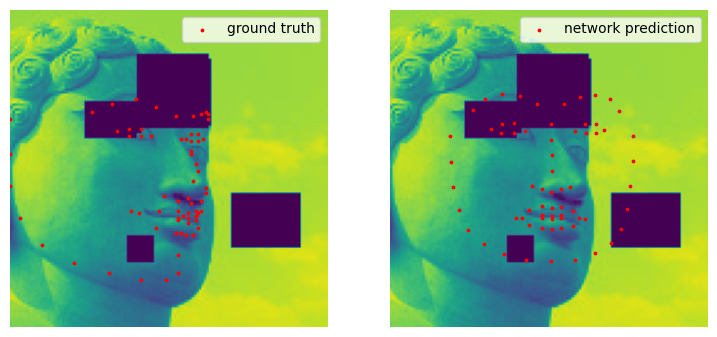

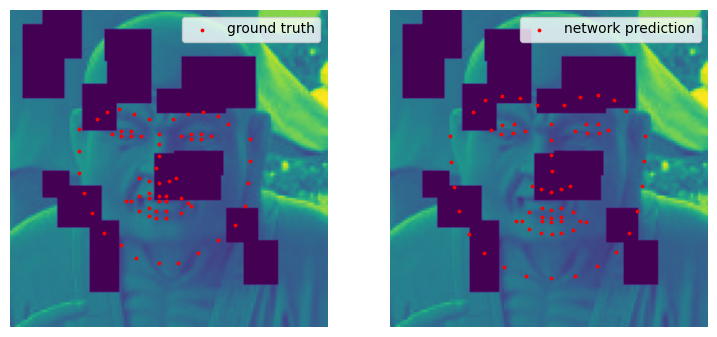

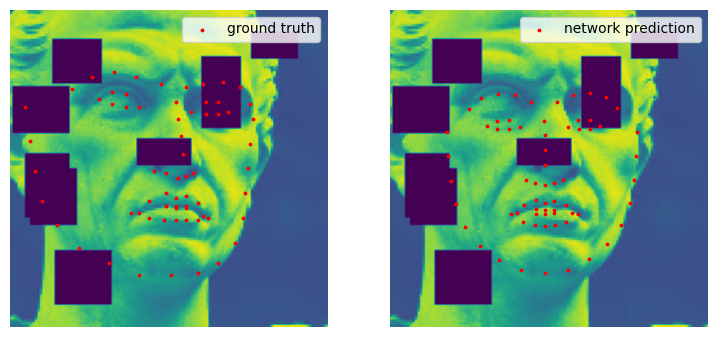

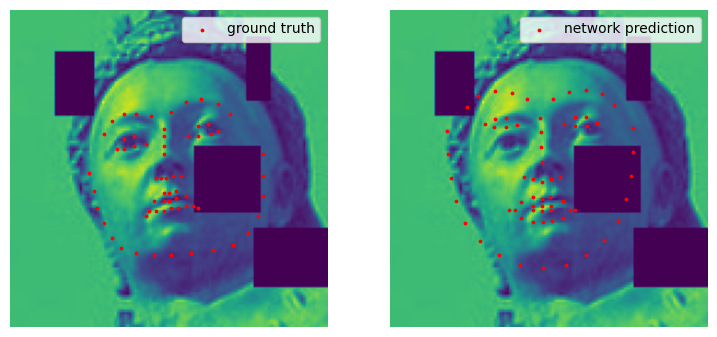

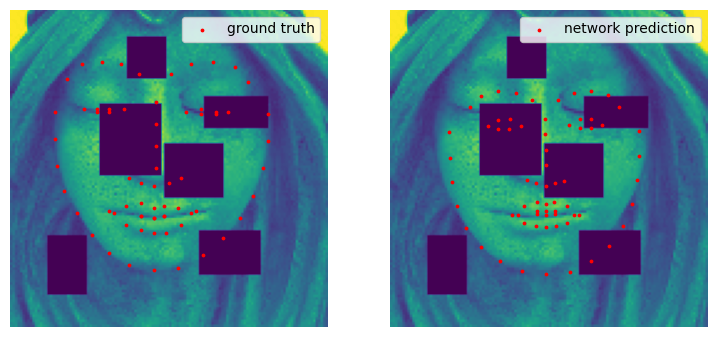

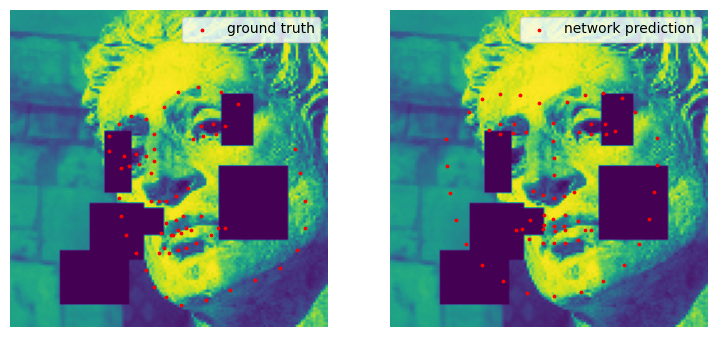

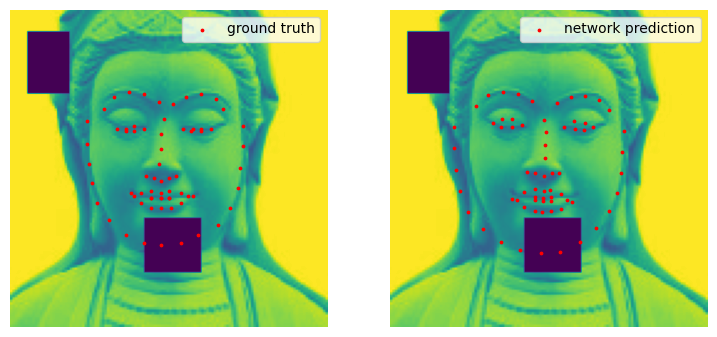

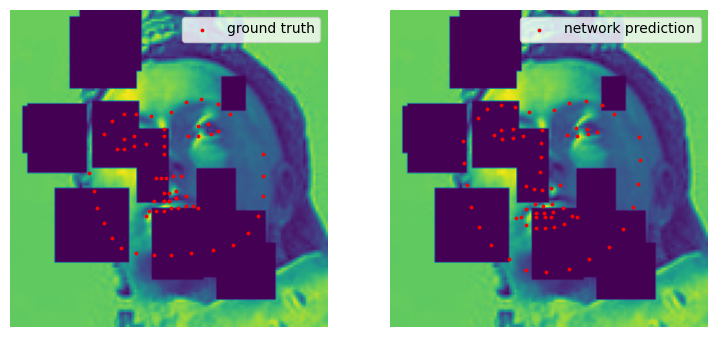

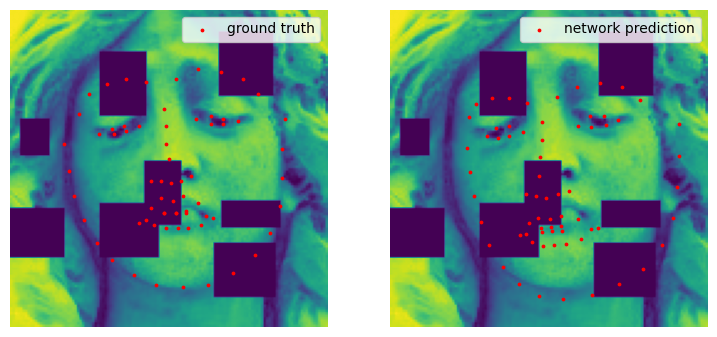

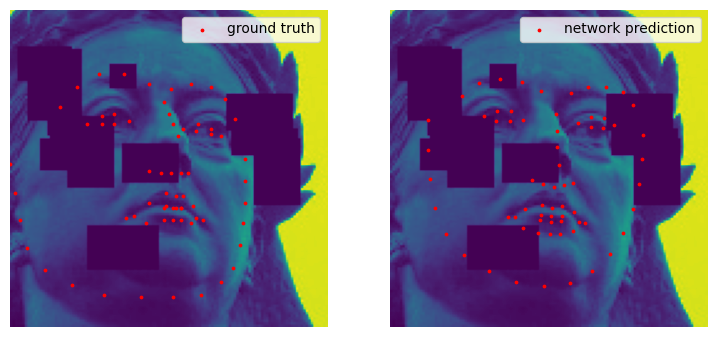

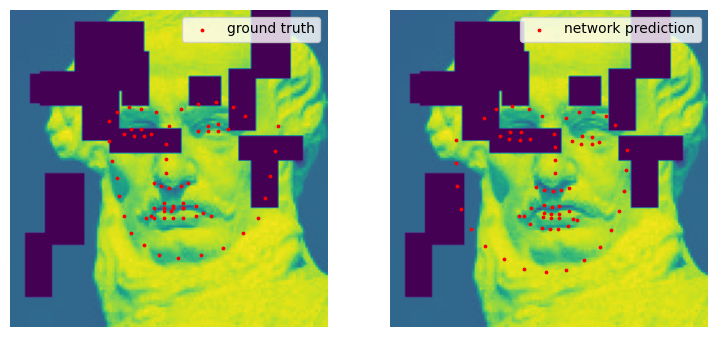

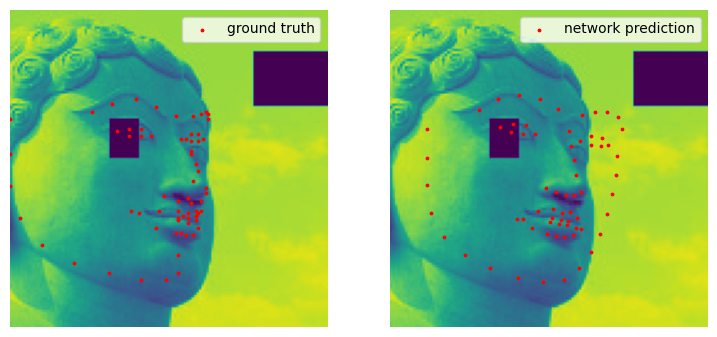

In [ ]:
num_epochs = 250
test_landmarks_predictor(False, 'test', test_loader, save=True)
while epoch <= num_epochs:
    epoch += 1
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    training_masks_number = random.randint(1, 3) * 4
    network.train()
    train_loader.dataset.set_masks_number(training_masks_number)
    test_loader.dataset.set_masks_number(training_masks_number)
    for step in range(1,len(train_loader)+1):


        images, landmarks = next(iter(train_loader))
        images = images
        landmarks = landmarks.view(landmarks.size(0),-1)

        predictions = network(images)

        # clear all the gradients before calculating them
        optimizer.zero_grad()

        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)

        # calculate the gradients
        loss_train_step.backward()

        # update the parameters
        optimizer.step()

        loss_train += loss_train_step.item()
        running_loss = loss_train/step

        #log_info(logfile_path, "Train Steps: %d/%d  Loss: %.4f \n" % (step, len(train_loader), running_loss))
    network.eval()
    with torch.no_grad():

        for step in range(1,len(test_loader)+1):

            images, landmarks = next(iter(test_loader))

            images = images
            landmarks = landmarks.view(landmarks.size(0),-1)

            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step
            log_info(logfile_path, "Valid Steps: %d/%d  Loss: %.4f \n" % (step, len(test_loader), running_loss))

    loss_train /= len(train_loader)
    loss_valid /= len(test_loader)

    log_info(logfile_path, '--------------------------------------------------\n')
    log_info(logfile_path, 'Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}\n'.format(epoch, loss_train, loss_valid))
    log_info(logfile_path, '--------------------------------------------------\n')
    if epoch % 4 == 0:
        test_landmarks_predictor(False, 'test', test_loader, save=True)
    epoch_array.append(epoch)
    train_loss_array.append(loss_train)
    valid_loss_array.append(loss_valid)

    if loss_valid < loss_min:
        loss_min = loss_valid
        mark_id = ''
        torch.save(network.state_dict(), f'/content/drive/MyDrive/Postgrado/Generated/resnet50_landmarkdetector/{train_id}.pth')
        log_info(logfile_path, "Minimum Validation Loss of {:.4f} at epoch {}/{}\n".format(loss_min, epoch, num_epochs))
        log_info(logfile_path, 'Model Saved\n\n')

log_info(logfile_path, 'Training Complete\n')
log_info(logfile_path, "Total Elapsed Time : {} s\n".format(time.time()-start_time))

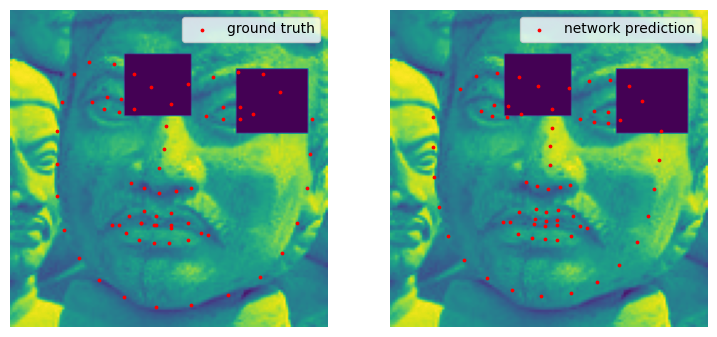

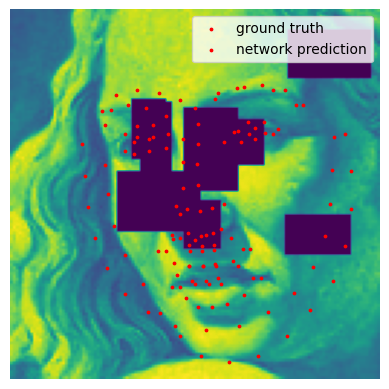

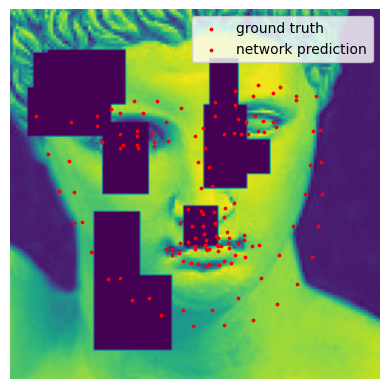

In [ ]:
test_landmarks_predictor(False, 'test', test_loader, save=False)

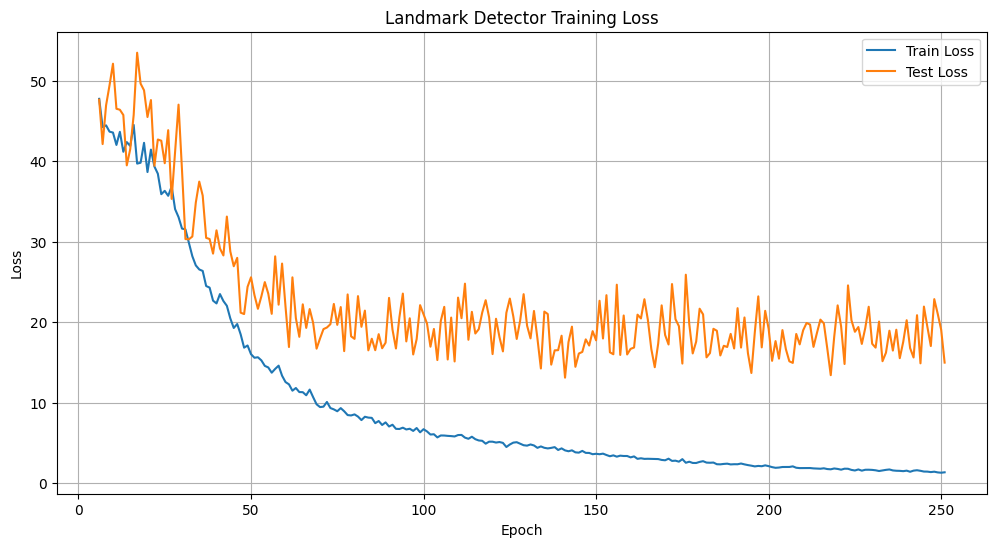

In [ ]:
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(epoch_array[5:], train_loss_array[5:], label='Train Loss')
plt.plot(epoch_array[5:], valid_loss_array[5:], label='Test Loss')
plt.legend(loc="upper right")
plt.title('Landmark Detector Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Pruebas en datos de entrenamiento

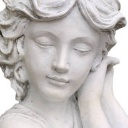

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(
    cv2.imread('/content/statues128/train/statue/istock_0998_cropped.jpg')
)

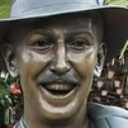

In [ ]:
cv2_imshow(cv2.imread('/content/statues128/train/statue/flickr_0285_cropped.jpg'))

### Pruebas en datos de testing

In [ ]:
train_id

'resnet50_landmarkdetector_2023-05-03_15:04:00'

In [ ]:
def test_landmarks_predictor(train, mode, dataloader, save=False):

    #dataset = LandmarksDataset(train = train, mode=mode, masks_number=5, verbose=False)
    #dataloader = torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=False)
    iterloader = iter(dataloader)
    fig = plt.figure(figsize=(9, 5))
    for i in range(3):

        images, real_landmarks = next(iterloader)

        # init figure

        #fig.suptitle(t=f'Figure: {dataloader.dataset.last_object.split("/")[-1]}')

        # show source image
        #ax0 = fig.add_subplot(1, 3, 1)
        #plt.imshow(cv2.imread(dataloader.dataset.last_object))

        # show ground truth landmarks
        ax1 = fig.add_subplot(1, 2, 1)
        plt.imshow(images[0][0].cpu())
        plt.scatter(real_landmarks[0].cpu()[:, 0], real_landmarks[0].cpu()[:, 1], s = 3, c = 'red', label='ground truth')
        plt.axis('off')
        plt.legend()


        # show predicted landmarks
        ax2 = fig.add_subplot(1, 2, 2)
        predicted_landmarks = network(images)
        predicted_landmarks = predicted_landmarks.detach()
        predicted_landmark0 = torch.reshape(predicted_landmarks[0], (68, 2))

        plt.imshow(images[0][0].cpu())
        plt.scatter(predicted_landmark0.cpu()[:, 0], predicted_landmark0.cpu()[:, 1], s = 3, c = 'red', label='network prediction')
        plt.axis('off')
        plt.legend()
        #plt.title('')
        #plt.show()
        if save:
            plt.savefig(f'/content/drive/MyDrive/Postgrado/Generated/resnet50/{train_id}_epoch-{epoch:03d}_img-{i}.png', bbox_inches='tight', pad_inches=0)
        else:
            plt.show()
        print('\n')


In [ ]:
f'{epoch:03d}'

'001'

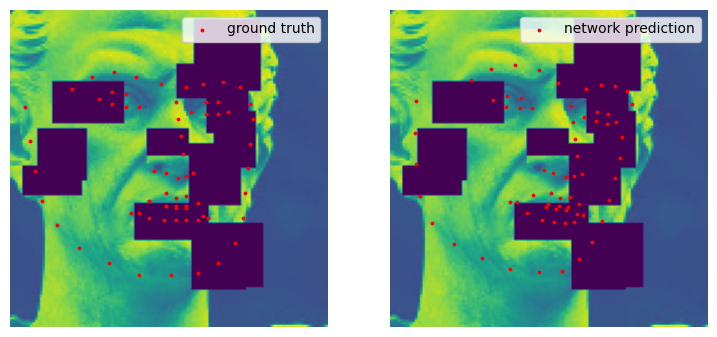

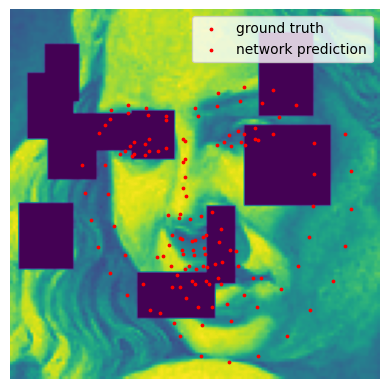

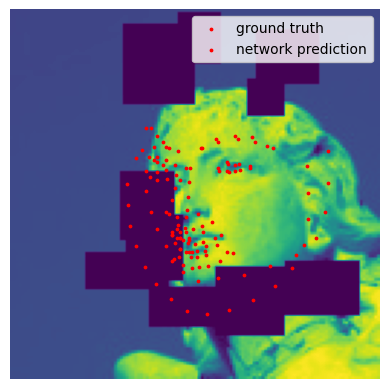

In [ ]:
test_landmarks_predictor(False, 'test', test_loader, save=False)

In [ ]:
import os
folder = '/content/drive/MyDrive/Postgrado/Generated/resnet50'
filenames = os.listdir(folder)

for i in range(0, 248+1):
    if i % 4 == 0:
        epoch = f'{i:03d}'
        content = (
            """
            \\begin{figure}[htp] \centering
            \\begin{subfigure}[b]{0.3\\textwidth} \centering  \includegraphics[width=\\textwidth]{assets/results/landmarkDetector/resnet50_landmarkdetector_2023-05-03_15_18_51_"""+f"epoch-{epoch}"+"""_img-0.png} \end{subfigure}
            \hfill
            \\begin{subfigure}[b]{0.3\\textwidth} \centering  \includegraphics[width=\\textwidth]{assets/results/landmarkDetector/resnet50_landmarkdetector_2023-05-03_15_18_51_"""+f"epoch-{epoch}"+"""_img-1.png} \end{subfigure}
            \hfill
            \\begin{subfigure}[b]{0.3\\textwidth}  \centering \includegraphics[width=\\textwidth]{assets/results/landmarkDetector/resnet50_landmarkdetector_2023-05-03_15_18_51_"""+f"epoch-{epoch}"+"""_img-2.png} \end{subfigure}
            \caption{Epoch """+f"{epoch}"+"""}
            \label{fig:landmark_detector_epoch_"""f"{epoch}"+"} \end{figure}"
        )
        print(content)



            \begin{figure}[htp] \centering 
            \begin{subfigure}[b]{0.3\textwidth} \centering  \includegraphics[width=\textwidth]{assets/results/landmarkDetector/resnet50_landmarkdetector_2023-05-03_15_18_51_epoch-000_img-0.png} \end{subfigure}
            \hfill
            \begin{subfigure}[b]{0.3\textwidth} \centering  \includegraphics[width=\textwidth]{assets/results/landmarkDetector/resnet50_landmarkdetector_2023-05-03_15_18_51_epoch-000_img-1.png} \end{subfigure}
            \hfill
            \begin{subfigure}[b]{0.3\textwidth}  \centering \includegraphics[width=\textwidth]{assets/results/landmarkDetector/resnet50_landmarkdetector_2023-05-03_15_18_51_epoch-000_img-2.png} \end{subfigure}
            \caption{Epoch 000}
            \label{fig:landmark_detector_epoch_000} \end{figure}

            \begin{figure}[htp] \centering 
            \begin{subfigure}[b]{0.3\textwidth} \centering  \includegraphics[width=\textwidth]{assets/results/landmarkDetector/resnet50_landmarkd

In [ ]:
with open("/content/drive/MyDrive/Postgrado/Generated/resnet50_landmarkdetector/resnet50_landmarkdetector_2023-05-03_15:18:51.log") as fp:
    lines = fp.readlines()

for line in lines:
    if line.startswith("Epoch:"):
        epoch = int(line.split("Train Loss")[0].replace("Epoch:", "").strip())

        train_loss = line.split("Train Loss")[1].split("Valid Loss")[0].replace(":", "").strip()
        valid_loss = line.split("Valid Loss: ")[1].strip()

        print(f"{epoch:03d} & {train_loss} & {valid_loss} \\\ ")

001 & 3503.4438 & 1178.9732 \\ 
002 & 1105.8997 & 521.8607 \\ 
003 & 313.6246 & 168.0496 \\ 
004 & 105.2461 & 67.2681 \\ 
005 & 55.7219 & 44.7907 \\ 
006 & 47.7625 & 47.6547 \\ 
007 & 44.2495 & 42.1451 \\ 
008 & 44.4733 & 46.9573 \\ 
009 & 43.6890 & 49.4441 \\ 
010 & 43.5764 & 52.1263 \\ 
011 & 42.0380 & 46.5317 \\ 
012 & 43.6656 & 46.4099 \\ 
013 & 41.1890 & 45.7560 \\ 
014 & 42.3912 & 39.5027 \\ 
015 & 41.9147 & 41.5140 \\ 
016 & 44.5238 & 45.7619 \\ 
017 & 39.7183 & 53.4926 \\ 
018 & 39.8259 & 49.6602 \\ 
019 & 42.2994 & 48.8224 \\ 
020 & 38.6718 & 45.5075 \\ 
021 & 41.4596 & 47.6125 \\ 
022 & 39.3655 & 39.4495 \\ 
023 & 38.4643 & 42.7121 \\ 
024 & 35.9203 & 42.5613 \\ 
025 & 36.3358 & 39.7670 \\ 
026 & 35.7198 & 43.8719 \\ 
027 & 36.8786 & 35.3340 \\ 
028 & 34.0633 & 41.1075 \\ 
029 & 33.0708 & 47.0432 \\ 
030 & 31.6487 & 38.9192 \\ 
031 & 31.5465 & 30.3455 \\ 
032 & 29.8844 & 30.3178 \\ 
033 & 28.2108 & 30.6639 \\ 
034 & 27.0767 & 34.8743 \\ 
035 & 26.5717 & 37.4843 \\ 
036 & 26.3